In [1]:
# Necessary imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# Load the dataset
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

data.head()


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Separating features and target
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

# Encoding target variable: Malignant (M) as 1, Benign (B) as 0
y = np.where(y == "M", 1, 0)

# Split the dataset to keep aside 100 samples from each class for testing
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]
y_class_0 = y[class_0_indices]
y_class_1 = y[class_1_indices]

# Separate 100 samples from each class for the test set
X_test_class_0, X_train_class_0 = X_class_0[:100], X_class_0[100:]
X_test_class_1, X_train_class_1 = X_class_1[:100], X_class_1[100:]
y_test_class_0, y_train_class_0 = y_class_0[:100], y_class_0[100:]
y_test_class_1, y_train_class_1 = y_class_1[:100], y_class_1[100:]

# Combine the class-separated training and test sets
X_train = np.concatenate((X_train_class_0, X_train_class_1))
y_train = np.concatenate((y_train_class_0, y_train_class_1))
X_test_small = np.concatenate((X_test_class_0, X_test_class_1))
y_test_small = np.concatenate((y_test_class_0, y_test_class_1))



In [4]:

np.random.seed(42)

# Determine the number of samples in the minority class
minority_class_size = min(len(X_train_class_0), len(X_train_class_1))

# Calculate the number of samples to duplicate from the majority class
majority_class_size = 3 * minority_class_size - len(X_train_class_1)

# Randomly select samples to duplicate from the majority class
indices_to_duplicate = np.random.choice(len(X_train_class_1), majority_class_size, replace=True)

# Extract the samples to be duplicated
X_to_duplicate = X_train_class_1[indices_to_duplicate]
y_to_duplicate = y_train_class_1[indices_to_duplicate]

# Add noise to the duplicated samples
noise_factor = 0.01
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_to_duplicate.shape)
X_to_duplicate_noisy = X_to_duplicate + noise

# Combine the original training data with the noisy duplicates
X_train_imbalanced = np.vstack((X_train, X_to_duplicate_noisy))
y_train_imbalanced = np.hstack((y_train, y_to_duplicate))


In [5]:
# Calculate the number of labels to flip for each class
num_to_flip_class_0 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 0]))
num_to_flip_class_1 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 1]))

# Randomly choose the indices of labels to flip
indices_to_flip_class_0 = np.random.choice(np.where(y_train_imbalanced == 0)[0], num_to_flip_class_0, replace=False)
indices_to_flip_class_1 = np.random.choice(np.where(y_train_imbalanced == 1)[0], num_to_flip_class_1, replace=False)

# Flip the labels
y_train_imbalanced[indices_to_flip_class_0] = 1
y_train_imbalanced[indices_to_flip_class_1] = 0



In [6]:

# Determine the number of input features (number of columns in X_train_imbalanced)
input_dim = X_train_imbalanced.shape[1]

# Create the neural network model with one hidden layer of size twice the number of input features
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and the ADAM optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


7/7 [==============================] - 0s 306us/step


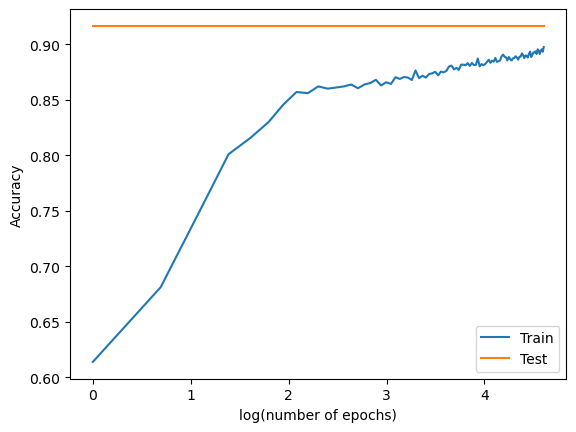

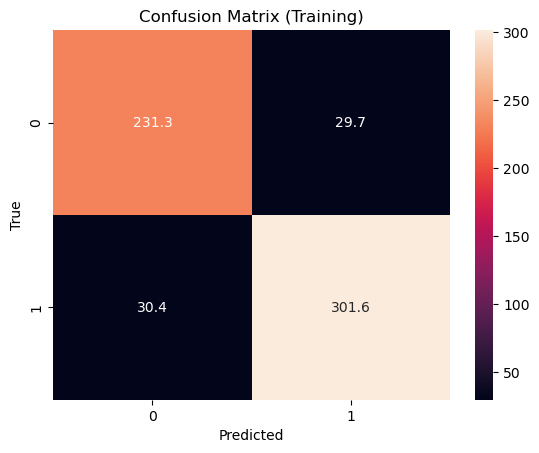

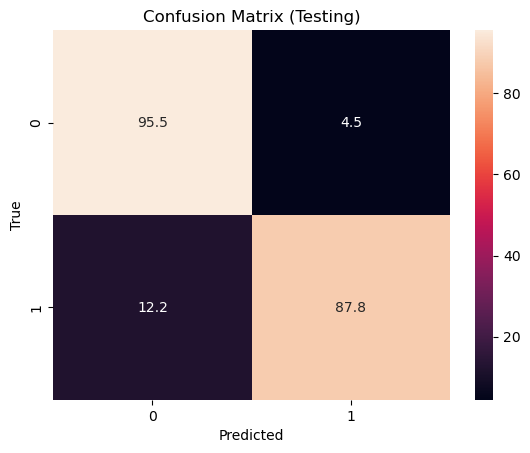

In [7]:


results_train = []
results_test = []
conf_mat_train = []
conf_mat_test = []
weights_list = []

for i in range(10): 
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

    # Save the weights
    weights = model.get_weights()
    weights_list.append(weights)

    # Evaluate the model
    train_acc = history.history['accuracy']
    test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)[1]

    # Save the results
    results_train.append(train_acc)
    results_test.append(test_acc)

    # Confusion matrices
    y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
    y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)

    conf_mat_train.append(confusion_matrix(y_train_imbalanced, y_pred_train))
    conf_mat_test.append(confusion_matrix(y_test_small, y_pred_test))

# Calculate the mean results
mean_results_train = np.mean(results_train, axis=0)
mean_results_test = np.mean(results_test)

# Plot the results
plt.plot(np.log(range(1, 101)), mean_results_train, label="Train")
plt.plot(np.log(range(1, 101)), [mean_results_test] * 100, label="Test")
plt.xlabel("log(number of epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Confusion matrices
mean_conf_mat_train = np.mean(conf_mat_train, axis=0)
mean_conf_mat_test = np.mean(conf_mat_test, axis=0)

# Plotting confusion matrices
plt.figure()
sns.heatmap(mean_conf_mat_train, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Training)")
plt.show()

plt.figure()
sns.heatmap(mean_conf_mat_test, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Testing)")
plt.show()

# Saving weights
file = open('weights.txt', 'w')
file.write(str(weights_list))
file.close()
